In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import tqdm
from torchvision import datasets, transforms, models
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tabulate import tabulate

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [36]:
CROPPED_IMAGES_SIZE = 224
N_CLASSES = 102
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
N_EPOCHS = 40

In [37]:
normalize_mean = np.array([0.485, 0.456, 0.406])
normalize_std = np.array([0.229, 0.224, 0.225])


# Training
# transform_train = transforms.Compose([
#   transforms.RandomRotation(45),
#   transforms.RandomHorizontalFlip(),
#   transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
#   transforms.ToTensor(),
#   transforms.Normalize(normalize_mean, normalize_std)
# ])
transform_train = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomRotation(180),
  transforms.RandomResizedCrop(CROPPED_IMAGES_SIZE),
  transforms.ToTensor(),
  transforms.Normalize(normalize_mean, normalize_std)
])
dataset_train = datasets.Flowers102(root="dataset/train", download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Validation
transform_validation = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(CROPPED_IMAGES_SIZE),
  transforms.ToTensor(),
  transforms.Normalize(normalize_mean, normalize_std)
])
dataset_validation = datasets.Flowers102(root="dataset/validation", download=True, transform=transform_validation, split="val")
validation_loader = torch.utils.data.DataLoader(dataset_validation, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Test
transform_test = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(CROPPED_IMAGES_SIZE),
  transforms.ToTensor(),
  transforms.Normalize(normalize_mean, normalize_std)
])

dataset_test = datasets.Flowers102(root="dataset/test", download=True, transform=transform_test, split="test")
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


In [38]:
# Download the model
# model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
# Replace the model classifier
# classifier = nn.Sequential(nn.Linear(512, 256),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.2),
#                         nn.Linear(256, 102),
#                         nn.LogSoftmax(dim=1)
#                         )

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
classifier = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(),
                        nn.Dropout(p=0.2),
                        nn.Linear(512, 102),
                        nn.LogSoftmax(dim=1)
                        )

# model = models.resnet152(weights='ResNet152_Weights.DEFAULT')
# classifier = nn.Sequential(nn.Linear(2048, 1024),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.2),
#                         nn.Linear(1024, 102),
#                         nn.LogSoftmax(dim=1)
#                         )

model.fc = classifier

# Move model to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [39]:
def check_accuracy(data_loader, model):
    n_corrects = 0
    n_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            # Sending data to device
            x = x.to(device)
            y = y.to(device)

            # Forward propagation
            y_hat = model(x)

            # Calculate accuracy
            _, predictions = y_hat.max(1)
            n_corrects += (predictions == y).sum()
            n_samples += predictions.size(0)

        perc = (n_corrects.item() / n_samples) * 100
        return (n_corrects.item(), n_samples, perc)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions": [], "Samples": [], "Accuracy": [], "Loss": []}
)

# Tensorboard writer
writer = SummaryWriter()

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    model.train()
    with tqdm.tqdm(train_loader, unit="batch") as tepoch:
      for i, data in enumerate(tepoch):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          

          # print statistics
          running_loss += loss.item()
    scheduler.step()
    current_lr = optimizer.state_dict()['param_groups'][0]['lr']
    n_corrects, n_samples, accuracy = check_accuracy(validation_loader, model)
    training_results_data.loc[len(training_results_data.index)] = [
        int(epoch + 1),
        int(n_corrects),
        int(n_samples),
        accuracy,
        running_loss,
    ]
    writer.add_scalar("Loss/train", running_loss, epoch)
    writer.add_scalar('Accuracy/validation', accuracy, epoch)
    print(f"Epoch {epoch + 1}, loss: {running_loss}, lr: {current_lr}")
    print(f"Accuracy: {n_corrects}/{n_samples} = {accuracy:.2f}%")
    
writer.flush()
print('Finished Training')

torch.save(model.state_dict(), 'model.pt')

100%|██████████| 16/16 [00:12<00:00,  1.33batch/s]


Epoch 1, loss: 73.7702784538269, lr: 0.0001
Accuracy: 78/1020 = 7.65%


100%|██████████| 16/16 [00:11<00:00,  1.35batch/s]


Epoch 2, loss: 72.11170959472656, lr: 0.0001
Accuracy: 268/1020 = 26.27%


100%|██████████| 16/16 [00:12<00:00,  1.31batch/s]


Epoch 3, loss: 67.4869978427887, lr: 0.0001
Accuracy: 386/1020 = 37.84%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 4, loss: 57.490894079208374, lr: 0.0001
Accuracy: 534/1020 = 52.35%


100%|██████████| 16/16 [00:11<00:00,  1.35batch/s]


Epoch 5, loss: 43.895432472229004, lr: 0.0001
Accuracy: 663/1020 = 65.00%


100%|██████████| 16/16 [00:11<00:00,  1.35batch/s]


Epoch 6, loss: 31.42710053920746, lr: 0.0001
Accuracy: 764/1020 = 74.90%


100%|██████████| 16/16 [00:12<00:00,  1.33batch/s]


Epoch 7, loss: 21.042168378829956, lr: 0.0001
Accuracy: 846/1020 = 82.94%


100%|██████████| 16/16 [00:12<00:00,  1.33batch/s]


Epoch 8, loss: 15.392122864723206, lr: 0.0001
Accuracy: 857/1020 = 84.02%


100%|██████████| 16/16 [00:12<00:00,  1.26batch/s]


Epoch 9, loss: 11.640070021152496, lr: 0.0001
Accuracy: 882/1020 = 86.47%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 10, loss: 8.724350541830063, lr: 0.0001
Accuracy: 895/1020 = 87.75%


100%|██████████| 16/16 [00:12<00:00,  1.33batch/s]


Epoch 11, loss: 6.570531338453293, lr: 0.0001
Accuracy: 920/1020 = 90.20%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 12, loss: 6.457452401518822, lr: 0.0001
Accuracy: 909/1020 = 89.12%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 13, loss: 5.552673161029816, lr: 0.0001
Accuracy: 918/1020 = 90.00%


100%|██████████| 16/16 [00:12<00:00,  1.31batch/s]


Epoch 14, loss: 4.716696545481682, lr: 0.0001
Accuracy: 922/1020 = 90.39%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 15, loss: 4.5405828058719635, lr: 0.0001
Accuracy: 923/1020 = 90.49%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 16, loss: 3.431905321776867, lr: 0.0001
Accuracy: 929/1020 = 91.08%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 17, loss: 4.038203299045563, lr: 0.0001
Accuracy: 927/1020 = 90.88%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 18, loss: 3.86802376806736, lr: 0.0001
Accuracy: 934/1020 = 91.57%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 19, loss: 3.5586897283792496, lr: 0.0001
Accuracy: 927/1020 = 90.88%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 20, loss: 3.0219541490077972, lr: 1e-05
Accuracy: 933/1020 = 91.47%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 21, loss: 3.055841848254204, lr: 1e-05
Accuracy: 932/1020 = 91.37%


100%|██████████| 16/16 [00:12<00:00,  1.33batch/s]


Epoch 22, loss: 3.9040060192346573, lr: 1e-05
Accuracy: 934/1020 = 91.57%


100%|██████████| 16/16 [00:11<00:00,  1.34batch/s]


Epoch 23, loss: 3.2636860832571983, lr: 1e-05
Accuracy: 935/1020 = 91.67%


100%|██████████| 16/16 [00:12<00:00,  1.24batch/s]


Epoch 24, loss: 2.772924728691578, lr: 1e-05
Accuracy: 939/1020 = 92.06%


100%|██████████| 16/16 [00:13<00:00,  1.20batch/s]


Epoch 25, loss: 2.741037029772997, lr: 1e-05
Accuracy: 939/1020 = 92.06%


100%|██████████| 16/16 [00:13<00:00,  1.18batch/s]


Epoch 26, loss: 2.158935822546482, lr: 1e-05
Accuracy: 943/1020 = 92.45%


100%|██████████| 16/16 [00:11<00:00,  1.33batch/s]


Epoch 27, loss: 2.0577730648219585, lr: 1e-05
Accuracy: 943/1020 = 92.45%


100%|██████████| 16/16 [00:12<00:00,  1.29batch/s]


Epoch 28, loss: 2.992121711373329, lr: 1e-05
Accuracy: 944/1020 = 92.55%


100%|██████████| 16/16 [00:13<00:00,  1.21batch/s]


Epoch 29, loss: 2.4469929337501526, lr: 1e-05
Accuracy: 944/1020 = 92.55%


100%|██████████| 16/16 [00:13<00:00,  1.19batch/s]


Epoch 30, loss: 2.5749445110559464, lr: 1e-05
Accuracy: 943/1020 = 92.45%


100%|██████████| 16/16 [00:13<00:00,  1.21batch/s]


Epoch 31, loss: 1.7362560257315636, lr: 1e-05
Accuracy: 944/1020 = 92.55%


100%|██████████| 16/16 [00:12<00:00,  1.33batch/s]


Epoch 32, loss: 2.0105949118733406, lr: 1e-05
Accuracy: 943/1020 = 92.45%


100%|██████████| 16/16 [00:14<00:00,  1.13batch/s]


Epoch 33, loss: 2.208995819091797, lr: 1e-05
Accuracy: 940/1020 = 92.16%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 34, loss: 2.369050722569227, lr: 1e-05
Accuracy: 942/1020 = 92.35%


100%|██████████| 16/16 [00:12<00:00,  1.26batch/s]


Epoch 35, loss: 2.262709517031908, lr: 1e-05
Accuracy: 946/1020 = 92.75%


100%|██████████| 16/16 [00:12<00:00,  1.31batch/s]


Epoch 36, loss: 2.7734922245144844, lr: 1e-05
Accuracy: 944/1020 = 92.55%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 37, loss: 2.571748446673155, lr: 1e-05
Accuracy: 946/1020 = 92.75%


100%|██████████| 16/16 [00:12<00:00,  1.23batch/s]


Epoch 38, loss: 2.3326503187417984, lr: 1e-05
Accuracy: 946/1020 = 92.75%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 39, loss: 2.230727653950453, lr: 1e-05
Accuracy: 946/1020 = 92.75%


100%|██████████| 16/16 [00:12<00:00,  1.32batch/s]


Epoch 40, loss: 2.2911267802119255, lr: 1.0000000000000002e-06
Accuracy: 944/1020 = 92.55%
Finished Training


Training/Validation results
╒═════════╤═══════════════════════╤════════════╤══════════╕
│   Epoch │ Predictions/Samples   │ Accuracy   │     Loss │
╞═════════╪═══════════════════════╪════════════╪══════════╡
│       1 │ 78/1020               │ 7.65%      │ 73.7703  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       2 │ 268/1020              │ 26.27%     │ 72.1117  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       3 │ 386/1020              │ 37.84%     │ 67.487   │
├─────────┼───────────────────────┼────────────┼──────────┤
│       4 │ 534/1020              │ 52.35%     │ 57.4909  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       5 │ 663/1020              │ 65.00%     │ 43.8954  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       6 │ 764/1020              │ 74.90%     │ 31.4271  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       7 │ 846/1020              │ 82.94%     │ 21.0422  │
├─────────┼─

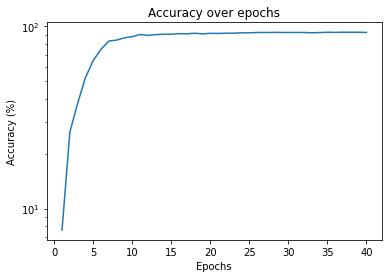

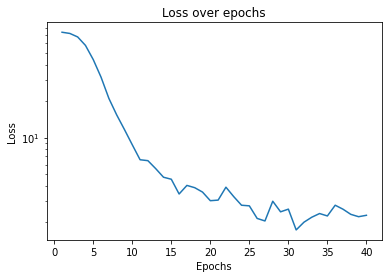

Testing results
Testing accuracy: 5596/6149 (91.01%)


<Figure size 18000x18000 with 0 Axes>

In [43]:
def createConfusionMatrix(data_loader, model):
    confusion_matrix = torch.zeros((102, 102))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    fig = plt.figure(figsize=(250,250))

    # confusion_matrix_np = confusion_matrix.numpy()
    # np.savetxt("confusion_matrix.csv", confusion_matrix_np, delimiter=",")
    
    # class_names = list(labelReference.values())
    df_cm = pd.DataFrame(confusion_matrix).astype(int)
    df_cm.to_csv('confusion_matrix.csv')

    # heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

    # heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
    # heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # return fig

print("Training/Validation results")
formatted_training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions/Samples": [], "Accuracy": [], "Loss": []}
)
for index, row in training_results_data.iterrows():
    formatted_training_results_data.loc[len(formatted_training_results_data.index)] = [
            row[0],
            f"{int(row[1])}/{int(row[2])}",
            f"{row[3]:.2f}%",
            f"{row[4]}",
        ]

print(tabulate(formatted_training_results_data, headers = 'keys', tablefmt = 'fancy_grid', showindex="never"))

plt.plot(training_results_data["Epoch"], training_results_data["Accuracy"])
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.yscale('log')
# plt.grid(True)
plt.show()

plt.plot(training_results_data["Epoch"], training_results_data["Loss"])
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
# plt.grid(True)
plt.show()

print("Testing results")
n_corrects, n_samples, accuracy = check_accuracy(test_loader, model)
print(f"Testing accuracy: {n_corrects}/{n_samples} ({accuracy:.2f}%)")
writer.add_figure("Confusion matrix", createConfusionMatrix(test_loader, model))
writer.flush()
writer.close()